# ASR workflow
* import raw_filt data
* crop 30-60sec as rawCaliAsr any apply yw_FILTER =====> emphersize non-neural activities
* extract VEOG_data from rawCaliAsr
* Mark blink and define raw_filt_eeg(exclude EOG channel from raw_filt)
* delete blinks in raw_fil_eeg and obtain rawdata_noblink
* peak-to-peak rejection to get SignalCalis
* use clean_window on SignalCalis to get SignalClean
* calculate threshold by doing cov and eigen decomposition on SignalClean
# Preprocessing worlflow

In [1]:
# -*- coding: utf-8 -*-
"""
build

updated on July 3th

@author:  Gansheng TAN: aegean0045@outlook.com based on Manu's codes and  learning from manu
"""

import mne
from mne import io
import scipy
import numpy as np
import numpy.matlib

import matplotlib.pyplot as plt
from mne.viz import plot_evoked_topo
from scipy.linalg import toeplitz
from scipy import signal
from utils_ASR import *

###############apply YW filter
apply_YW = True


#### import filt data #####

filt_data_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/filt_data/'
subj = '94'
state = 'FA1'
raw_filt_fname = filt_data_path + 'subj0'+str(subj)+'_'+state+'_filt_raw.fif'
raw_filt = io.read_raw_fif(raw_filt_fname,preload=True)

###################" we do not mark Pz as bad for the moment"
raw_filt.info['bads']=[]

#raw_filt.crop(tmin=0.0,tmax=150.0)
print("check raw_filt's shape")
print('shape of raw_filt is {}'.format(raw_filt.get_data().shape))
rawCalibAsr = raw_filt.copy()
rawCalibAsr = rawCalibAsr.crop(tmin=60,tmax=90)
rawCalibAsr_noYW = rawCalibAsr.copy()
# y_w filter as a huristic filter - filter the neural activities
#### filter parameter is defined in YW_filter function the None means we do not predefine iir filter 
if apply_YW == True:
    rawCalibAsr._data,iirstate = YW_filter(rawCalibAsr._data, rawCalibAsr.info['sfreq'],None)


rawVEOG= rawCalibAsr.copy()
rawVEOG = rawVEOG.pick_channels(['VEOG'])
VEOG_data = np.squeeze(rawVEOG.get_data())
# raw_filt.pick_types(eeg=True)
print('after pick channel, rawCaliAsr SHOULD NOT !!! contains only VEOG channel, time should be {}'.format(512*30))
print('shape of rawCaliAsr is {}'.format(rawCalibAsr.get_data().shape))
print('VEOG data length should be identical with rawCaliAsr, which is {}'.format(len(VEOG_data)))

Opening raw data file /home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/filt_data/subj094_FA1_filt_raw.fif...
    Range : 0 ... 294399 =      0.000 ...   574.998 secs
Ready.
Reading 0 ... 294399  =      0.000 ...   574.998 secs...
check raw_filt's shape
shape of raw_filt is (66, 294400)
after pick channel, rawCaliAsr SHOULD NOT !!! contains only VEOG channel, time should be 15360
shape of rawCaliAsr is (66, 15361)
VEOG data length should be identical with rawCaliAsr, which is 15361


In [2]:
# check data
# %matplotlib qt
# raw_filt.plot()

#use 30s-60s data as calibration data

################ parameter thresh!!!
peak_locs, peak_eeg = mne.preprocessing.peak_finder(VEOG_data, thresh = 75e-6)

# remove blinks from baseline data
lengthblink = 0.5*raw_filt.info['sfreq']
startremoveblink = peak_locs-(lengthblink/2)

stopremoveblink = peak_locs+(lengthblink/2)
NbsampCalibAsrWindow = len(VEOG_data)
startremoveblink = np.abs((startremoveblink>0)*startremoveblink)
# to make sure that no negative value, not necessary
stopremoveblink =  (stopremoveblink>NbsampCalibAsrWindow-1)*NbsampCalibAsrWindow + (stopremoveblink<NbsampCalibAsrWindow-1)*stopremoveblink
Mask=np.zeros(NbsampCalibAsrWindow)
for ix2remove in range(len(startremoveblink)):
    Mask[int(startremoveblink[ix2remove]):int(stopremoveblink[ix2remove])]=1
print('shape of raw_filt is {}'.format(raw_filt.get_data().shape))
rawCalibAsr_noYW.pick_types(eeg=True)
print('shape of rawCalibAsr_noYW is {}'.format(rawCalibAsr_noYW.get_data().shape))
rawdata_noblink = np.delete(rawCalibAsr_noYW.get_data(),np.where(Mask),axis=1)
print('shape of rawdata_noblink is {}'.format(rawdata_noblink.shape))

## THE THRESHOLD HERE IS VERY IMPORTANT I take 50e-6 just to test the implementation
SignalCalib=np.delete(rawdata_noblink,np.where(np.abs(rawdata_noblink)>50e-6)[1],axis=1)

ref_maxbadchannels = 0.2;
ref_tolerances = [-3.5,5.5];
ref_wndlen = 1;
print('shape of SignalCalip is {}'.format(SignalCalib.shape))
SignalClean,sample_mask = clean_windows(SignalCalib,raw_filt.info['sfreq'],ref_maxbadchannels,ref_tolerances,ref_wndlen);
print('shape of SignalClean is {}'.format(SignalClean.shape))
srate = raw_filt.info['sfreq']
# once we get Xc, we calculate Cov(Xc) then decompose eigenvalue to get threshold _ the cov represents the 
# pure neuro activity cov, other artifact should not be correlated theoratically 


shape of raw_filt is (66, 294400)
shape of rawCalibAsr_noYW is (64, 15361)
shape of rawdata_noblink is (64, 2678)
shape of SignalCalip is (64, 2666)
N is 512
S is 2666
offsets are [   0  174  348  522  696  870 1044 1218 1392 1566 1740 1914 2088]
Determining time window rejection thresholds...
for each channel...
shape of SignalClean is (64, 946)


In [16]:
cutoff = 20
asr_state = asr_calibrate(SignalClean,srate,cutoff)

Determining per-component thresholds...
done.


In [17]:
# load epochs and apply asr on each epochs
#### I still read VEOG and HEOG in epochs_raw, but it it not necessary
# use epochs.pick_types(eeg=True)
raw4detect = raw_filt.copy()
raw4detect.pick_types(eeg=True)
raw_filt_eeg=raw_filt.copy()
raw_filt_eeg.pick_types(eeg=True)

raw4detect._data,iirstate = YW_filter(raw4detect._data,raw4detect.info['sfreq'],None)
events_998=np.array([512, 0, 998])
for i in np.arange(512*2,574*512,512*2):
    events_998=np.vstack((events_998,np.array([i, 0, 998])))
event_id = {'2sec segment': 998}
events = mne.events_from_annotations(raw_filt)
events=np.asarray(events[0])
events = np.array(np.vstack((events_998,events)))
events=events[events[:,0].argsort()]
epochs4detect=mne.Epochs(raw4detect,events=events, event_id = event_id, tmin=-1, tmax=1,preload=True)
epochs_filt=mne.Epochs(raw_filt_eeg,events=events, event_id = event_id, tmin=-1, tmax=1,preload=True)
Data4detect = epochs4detect.get_data()
Data2correct = epochs_filt.get_data()
DataClean = np.zeros((Data2correct.shape))
for i_epoch in range(Data2correct.shape[0]):
    Epoch4detect = Data4detect[i_epoch,:,:] 
    Epoch2corr = Data2correct[i_epoch,:,:]    
    DataClean[i_epoch,:,:] = asr_process_on_epoch(Epoch2corr,Epoch4detect,asr_state)


Used Annotations descriptions: ['254.0', '131.0', '102.0', '101.0', '132.0', '100.0', '12.0', '255.0', '1.0', '21.0']
287 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 287 events and 1025 original time points ...
0 bad epochs dropped
287 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 287 events and 1025 original time points ...
0 bad epochs dropped


In [27]:
print('verify clean data shape, is it 287 epochs? {}'.format(DataClean.shape))
epochs_clean =   mne.EpochsArray(DataClean,info=epochs_filt.info)


verify clean data shape, is it 287 epochs? (287, 64, 1025)
287 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


In [28]:
###Autorej after ASR
from autoreject import AutoReject
ar = AutoReject(random_state=11,verbose='tqdm')
ar=ar.fit(epochs_clean)

Running autoreject on ch_type=eeg



Computing thresholds ...:  62%|██████▎   | 40/64 [02:55<01:44,  4.36s/it]


Computing thresholds ...: 100%|██████████| 64/64 [04:43<00:00,  4.52s/it]

Repairing epochs:   0%|          | 0/287 [00:00<?, ?it/s]

Repairing epochs:   6%|▌         | 17/287 [00:00<00:01, 164.44it/s]

Repairing epochs:  12%|█▏        | 34/287 [00:00<00:01, 164.00it/s]

Repairing epochs:  18%|█▊        | 51/287 [00:00<00:01, 164.05it/s]

Repairing epochs:  23%|██▎       | 67/287 [00:00<00:01, 162.34it/s]

Repairing epochs:  29%|██▉       | 84/287 [00:00<00:01, 162.44it/s]

Repairing epochs:  34%|███▍      | 98/287 [00:00<00:01, 149.08it/s]

Repairing epochs:  40%|████      | 115/287 [00:00<00:01, 152.97it/s]

Repairing epochs:  46%|████▌     | 132/287 [00:00<00:00, 156.08it/s]

Repairing epochs:  52%|█████▏    | 149/287 [00:00<00:00, 158.16it/s]

Repairing epochs:  58%|█████▊    | 166/287 [00:01<00:00, 159.70it/s]

Repairing epochs:  64%|██████▍   | 183/287 [00:01<00:00, 160.72it/s]

Repairing epochs:  70%|██████▉   | 200/287 [00:01<00:00, 161.64it/s]

Repairing epochs:  76%|███████▌ 

Repairing epochs:  94%|█████████▍| 271/287 [00:07<00:00, 36.67it/s]

Repairing epochs:  96%|█████████▌| 275/287 [00:07<00:00, 36.96it/s]

Repairing epochs:  97%|█████████▋| 279/287 [00:07<00:00, 37.09it/s]

Repairing epochs:  99%|█████████▊| 283/287 [00:07<00:00, 37.54it/s]

Repairing epochs: 100%|██████████| 287/287 [00:07<00:00, 37.64it/s]


Fold:   0%|          | 0/10 [00:00<?, ?it/s]


Fold:  10%|█         | 1/10 [00:04<00:36,  4.05s/it]


Fold:  20%|██        | 2/10 [00:08<00:32,  4.06s/it]


Fold:  30%|███       | 3/10 [00:12<00:28,  4.05s/it]


Fold:  40%|████      | 4/10 [00:16<00:24,  4.04s/it]


Fold:  50%|█████     | 5/10 [00:20<00:20,  4.05s/it]


Fold:  60%|██████    | 6/10 [00:24<00:16,  4.04s/it]


Fold:  70%|███████   | 7/10 [00:28<00:12,  4.07s/it]


Fold:  80%|████████  | 8/10 [00:32<00:08,  4.08s/it]


Fold:  90%|█████████ | 9/10 [00:36<00:04,  4.07s/it]


n_interp:  33%|███▎      | 1/3 [00:50<01:40, 50.04s/it]

Repairing epochs:   0%|          | 0/287 [00:00<?, ?it/

Repairing epochs:  34%|███▍      | 98/287 [00:02<00:04, 39.86it/s]

Repairing epochs:  36%|███▌      | 103/287 [00:02<00:04, 40.32it/s]

Repairing epochs:  38%|███▊      | 108/287 [00:02<00:04, 41.25it/s]

Repairing epochs:  39%|███▉      | 113/287 [00:02<00:04, 41.48it/s]

Repairing epochs:  41%|████      | 118/287 [00:03<00:04, 41.21it/s]

Repairing epochs:  43%|████▎     | 123/287 [00:03<00:03, 41.37it/s]

Repairing epochs:  45%|████▍     | 128/287 [00:03<00:03, 41.32it/s]

Repairing epochs:  46%|████▋     | 133/287 [00:03<00:03, 40.97it/s]

Repairing epochs:  48%|████▊     | 138/287 [00:03<00:03, 40.86it/s]

Repairing epochs:  50%|████▉     | 143/287 [00:03<00:03, 40.95it/s]

Repairing epochs:  52%|█████▏    | 148/287 [00:03<00:03, 40.82it/s]

Repairing epochs:  53%|█████▎    | 153/287 [00:03<00:03, 40.97it/s]

Repairing epochs:  55%|█████▌    | 158/287 [00:04<00:03, 40.01it/s]

Repairing epochs:  57%|█████▋    | 163/287 [00:04<00:03, 40.61it/s]

Repairing epochs:  59%|█████▊    | 





Estimated consensus=0.90 and n_interpolate=32




Repairing epochs:   0%|          | 0/287 [00:00<?, ?it/s]

Repairing epochs:   1%|▏         | 4/287 [00:00<00:07, 37.78it/s]

Repairing epochs:   3%|▎         | 8/287 [00:00<00:07, 36.90it/s]

Repairing epochs:   4%|▍         | 12/287 [00:00<00:07, 36.95it/s]

Repairing epochs:   5%|▌         | 15/287 [00:00<00:08, 33.84it/s]

Repairing epochs:   7%|▋         | 19/287 [00:00<00:07, 34.15it/s]

Repairing epochs:   8%|▊         | 23/287 [00:00<00:07, 34.12it/s]

Repairing epochs:   9%|▉         | 27/287 [00:00<00:07, 34.16it/s]

Repairing epochs:  11%|█         | 31/287 [00:00<00:07, 33.35it/s]

Repairing epochs:  12%|█▏        | 35/287 [00:01<00:07, 34.81it/s]

Repairing epochs:  14%|█▎        | 39/287 [00:01<00:07, 34.36it/s]

Repairing epochs:  15%|█▍        | 43/287 [00:01<00:07, 34.24it/s]

Repairing epochs:  16%|█▋        | 47/287 [00:01<00:06, 34.37it/s]

Repairing epochs:  18%|█▊        | 51/287 [00:01<00:06, 34.27it/s]

Repairing epochs:  19%|█▉        | 55/287 [00:01<00:06, 3

Dropped 4 epochs


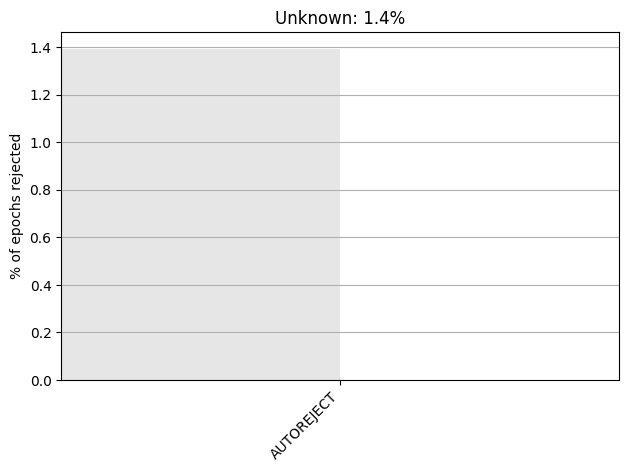

In [29]:
#### Autorej results check
epochs_clean_autorej, reject_log = ar.transform(epochs_clean, return_log=True)
epochs_clean_autorej.plot_drop_log()

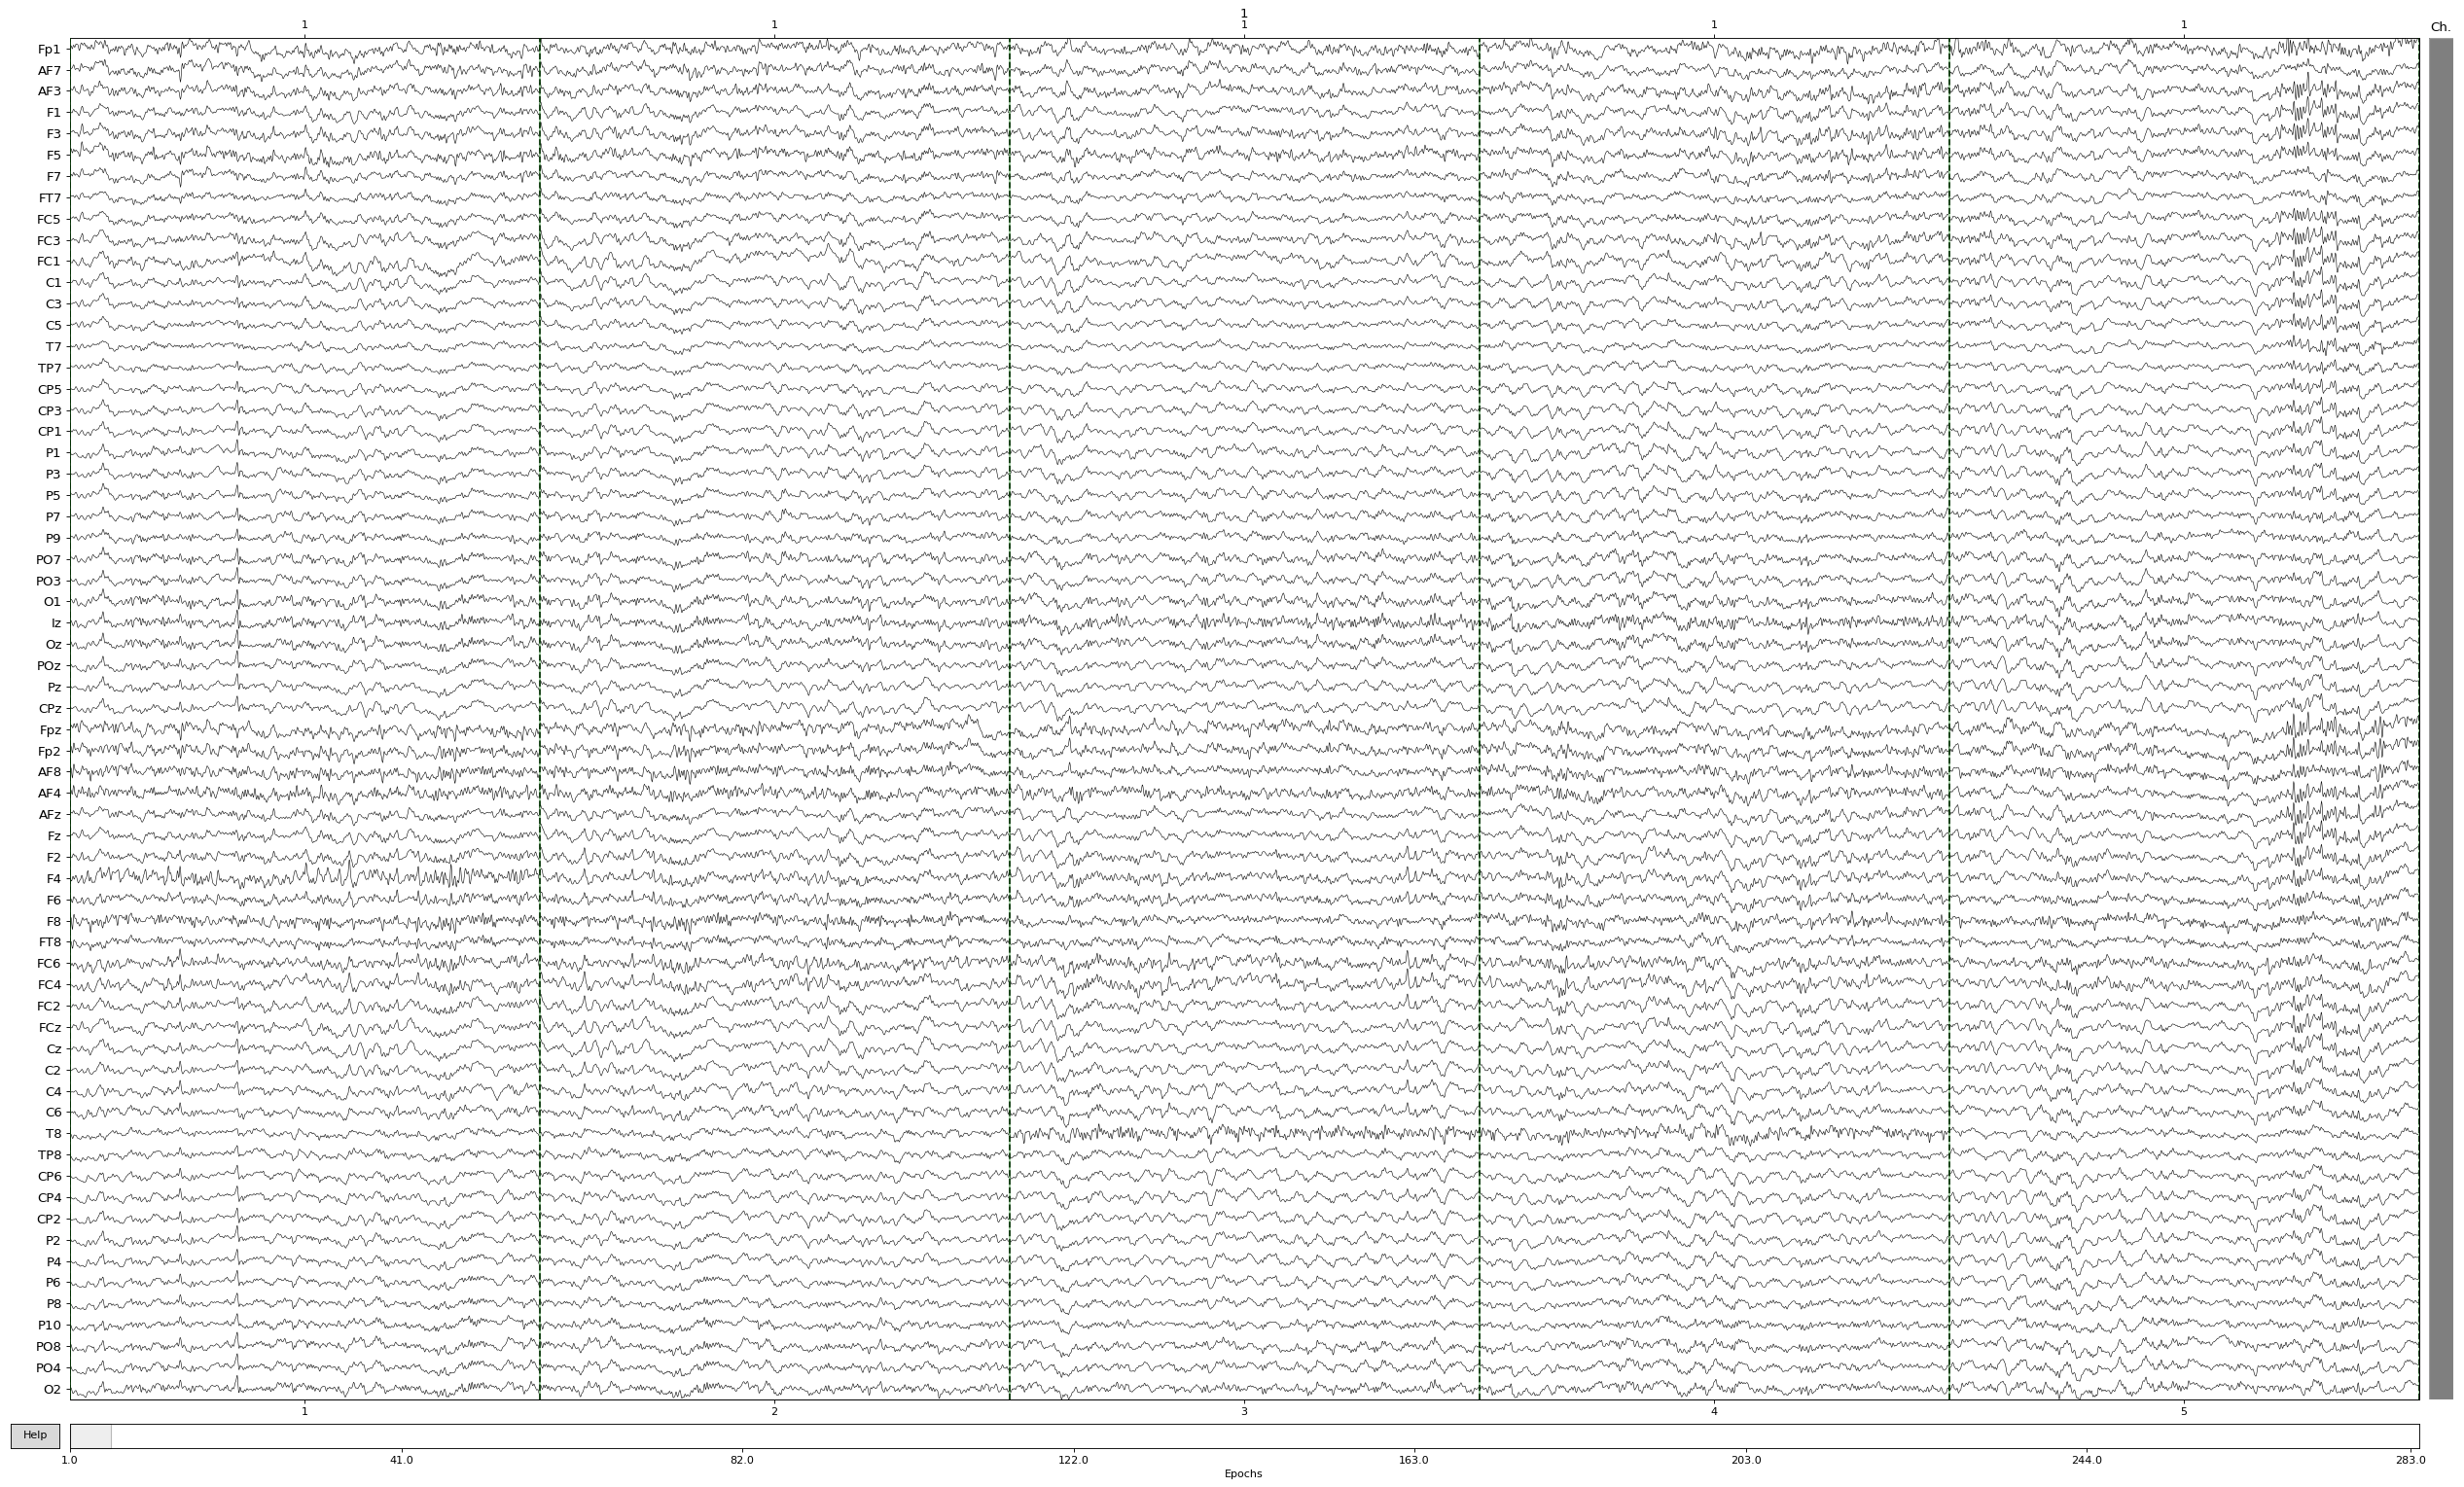

In [35]:
#reject_log.plot_epochs(epochs_clean)
epochs_clean_autorej.plot(n_epochs=5, n_channels = 64, scalings = 125e-6)

In [51]:
reject_log.labels[28,:]

array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 0., 0., 0., 2., 0., 0., 1.,
       0., 0., 0., 0., 2., 2., 2., 2., 2., 0., 2., 2., 2., 2., 0., 2., 2.,
       2., 2., 2., 0., 0., 2., 2., 2., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 2., 0., 0., 0., 2., 0., 0., 0.])

Dropped 0 epochs
Channels marked as bad: []


In [18]:
# Test quality 
# use ICA components and VEOG correlation
#Automated process
pca_n_comp=0.98
decim =3
ica = mne.preprocessing.ICA(n_components=pca_n_comp, method='fastica', random_state=11, max_iter=100)
ica.fit(epochs_clean,decim=decim)


Fitting ICA to data using 64 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selection by explained variance: 33 components
Fitting ICA took 17.0s.


<ICA  |  epochs decomposition, fit (fastica): 98154 samples, 33 components, channels used: "eeg">

Used Annotations descriptions: ['254.0', '131.0', '102.0', '101.0', '132.0', '100.0', '12.0', '255.0', '1.0', '21.0']


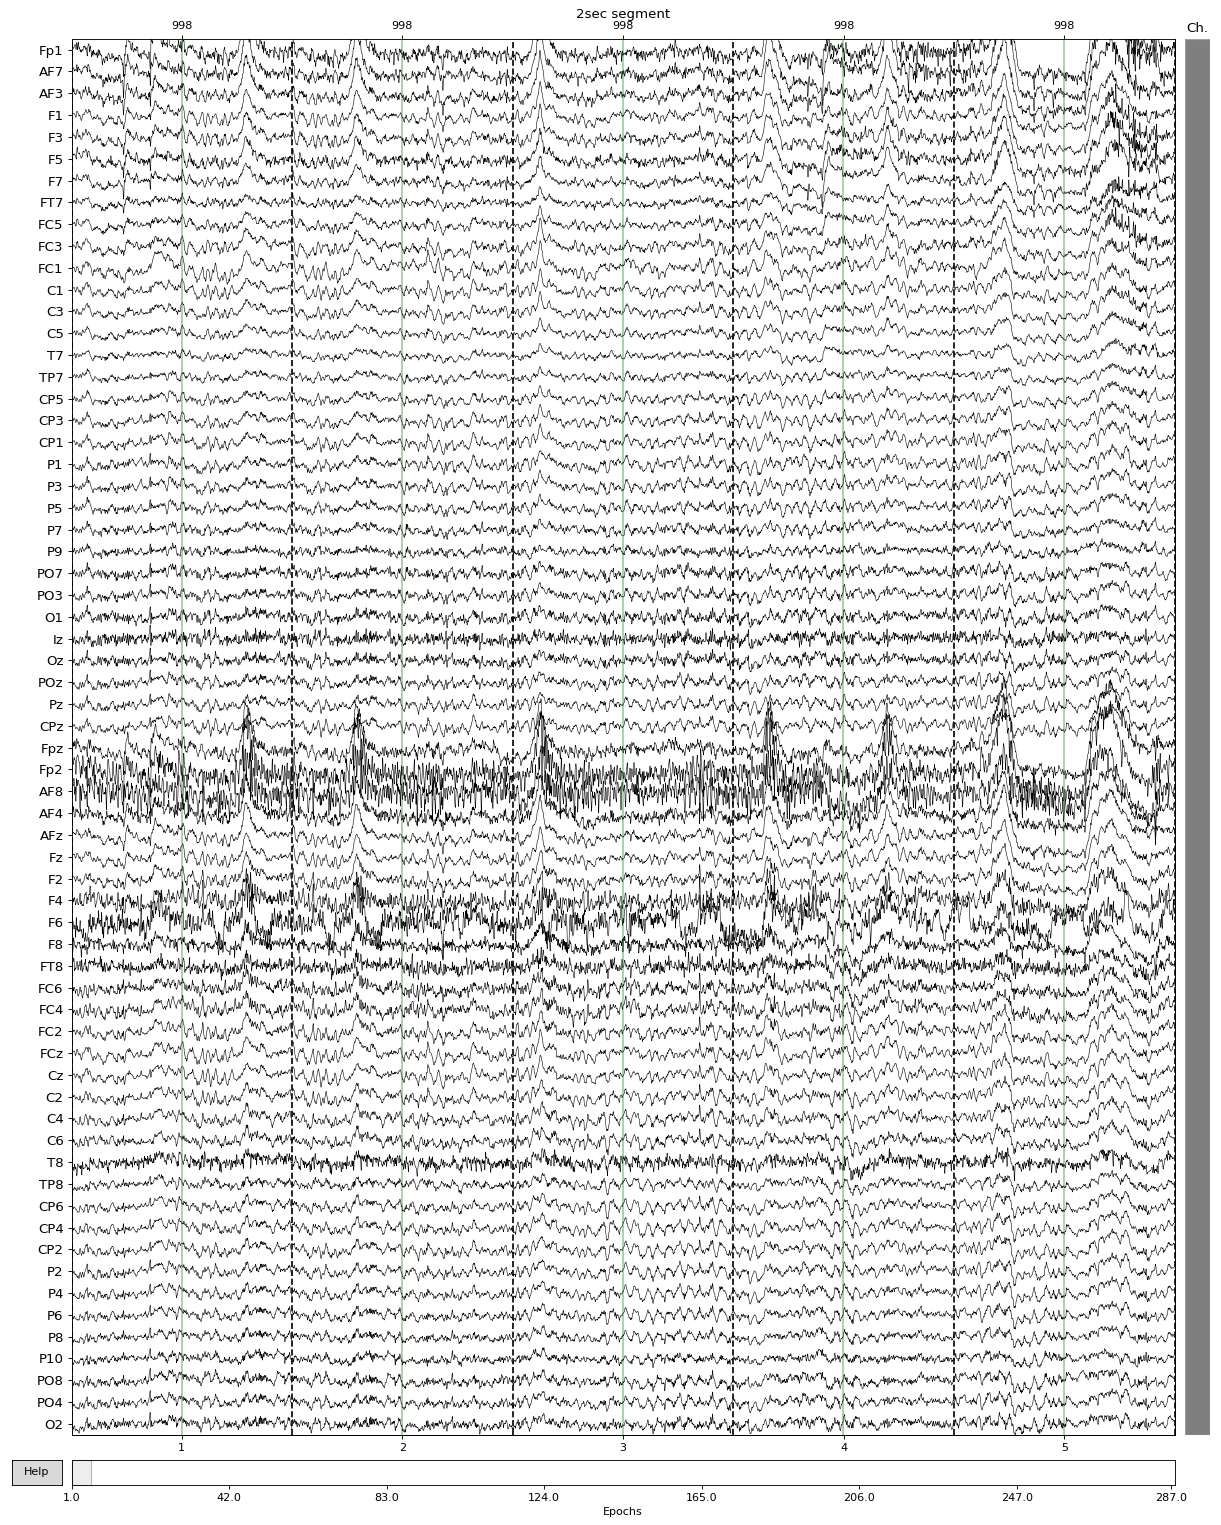

Dropped 0 epochs
Channels marked as bad: []
Dropped 0 epochs
Channels marked as bad: []


In [15]:
%matplotlib qt
shocks = events[:,2]
np.where(shocks == 4)
events[np.where(shocks == 4),0]/2/512

event_original=mne.events_from_annotations(raw_filt)
#raw_filt.plot(duration = 30, start= 0, n_channels = 64)


epochs_clean.plot(n_epochs=5, n_channels = 64, scalings = 125e-6)
epochs_filt.plot(n_epochs=5, n_channels = 64, scalings = 125e-6)

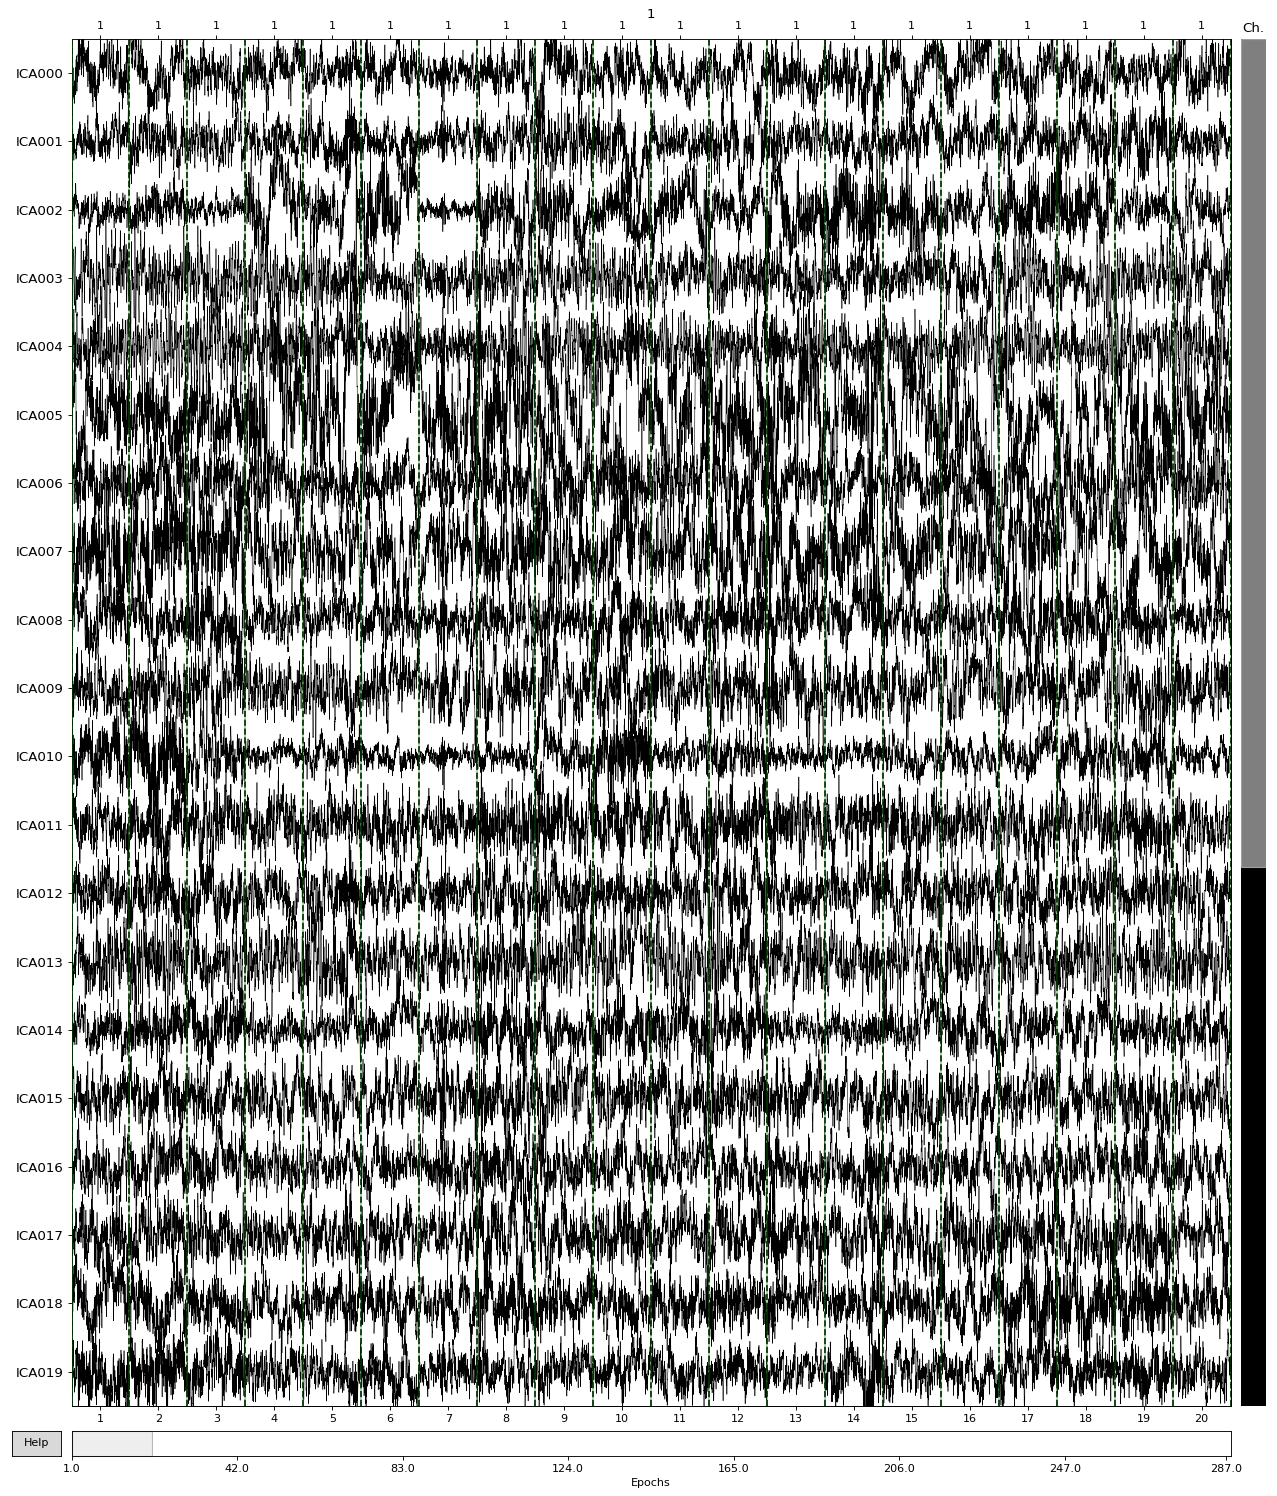

    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows


/home/gansheng.tan/mne/local/lib/python3.5/site-packages/mne/viz/epochs.py:1258: RuntimeWarning: divide by zero encountered in double_scalars
  ticks = np.arange(0, ylim, ylim / (4 * len(chan_types_split)))
Traceback (most recent call last):
  File "/home/gansheng.tan/mne/local/lib/python3.5/site-packages/matplotlib/cbook/__init__.py", line 215, in process
    func(*args, **kwargs)
  File "/home/gansheng.tan/mne/local/lib/python3.5/site-packages/mne/viz/epochs.py", line 1682, in _plot_onkey
    params['plot_fun']()
  File "/home/gansheng.tan/mne/local/lib/python3.5/site-packages/mne/viz/epochs.py", line 1275, in _plot_traces
    ydata = offset - this_data
UnboundLocalError: local variable 'offset' referenced before assignment
Traceback (most recent call last):
  File "/home/gansheng.tan/mne/local/lib/python3.5/site-packages/matplotlib/cbook/__init__.py", line 215, in process
    func(*args, **kwargs)
  File "/home/gansheng.tan/mne/local/lib/python3.5/site-packages/mne/viz/epochs.py", l

Dropped 0 epochs
Channels marked as bad: []
Dropped 0 epochs
Channels marked as bad: []


Traceback (most recent call last):
  File "/home/gansheng.tan/mne/local/lib/python3.5/site-packages/matplotlib/cbook/__init__.py", line 215, in process
    func(*args, **kwargs)
  File "/home/gansheng.tan/mne/local/lib/python3.5/site-packages/mne/viz/epochs.py", line 1682, in _plot_onkey
    params['plot_fun']()
  File "/home/gansheng.tan/mne/local/lib/python3.5/site-packages/mne/viz/epochs.py", line 1275, in _plot_traces
    ydata = offset - this_data
UnboundLocalError: local variable 'offset' referenced before assignment


Dropped 0 epochs
Channels marked as bad: []


In [23]:
ica.plot_components(inst=epochs_clean)
ica.get_sources(epochs_clean).plot(picks='all')

In [25]:
# -*- coding: utf-8 -*-
"""
build

updated on July 3th

@author:  based on Manu's codes and  learning from manu
"""

import mne
from mne import io
import scipy
import numpy as np
import numpy.matlib

import matplotlib.pyplot as plt
from mne.viz import plot_evoked_topo
from scipy.linalg import toeplitz
from scipy import signal

def clean_windows(Signal,srate,max_bad_channels,zthresholds,window_len):
# Remove periods with abnormally high-power content from continuous data.
# [Signal,Mask] = clean_windows(Signal,MaxBadChannels,PowerTolerances,WindowLength,WindowOverlap,MaxDropoutFraction,Min)
#
# This function cuts segments from the data which contain high-power artifacts. Specifically,
# only windows are retained which have less than a certain fraction of "bad" channels, where a channel
# is bad in a window if its power is above or below a given upper/lower threshold (in standard 
# deviations from a robust estimate of the EEG power distribution in the channel).
#
# In:
#   Signal         : Continuous data set, assumed to be appropriately high-passed (e.g. >1Hz or
#                    0.5Hz - 2.0Hz transition band)
#
#   MaxBadChannels : The maximum number or fraction of bad channels that a retained window may still
#                    contain (more than this and it is removed). Reasonable range is 0.05 (very clean
#                    output) to 0.3 (very lax cleaning of only coarse artifacts). Default: 0.2.
#
#   PowerTolerances: The minimum and maximum standard deviations within which the power of a channel
#                    must lie (relative to a robust estimate of the clean EEG power distribution in 
#                    the channel) for it to be considered "not bad". Default: [-3.5 5].
#
#
#   The following are detail parameters that usually do not have to be tuned. If you can't get
#   the function to do what you want, you might consider adapting these to your data.
#
#   WindowLength    : Window length that is used to check the data for artifact content. This is 
#                     ideally as long as the expected time scale of the artifacts but not shorter 
#                     than half a cycle of the high-pass filter that was used. Default: 1.
#
#   WindowOverlap : Window overlap fraction. The fraction of two successive windows that overlaps.
#                   Higher overlap ensures that fewer artifact portions are going to be missed (but
#                   is slower). (default: 0.66)
# 
#   MaxDropoutFraction : Maximum fraction that can have dropouts. This is the maximum fraction of
#                        time windows that may have arbitrarily low amplitude (e.g., due to the
#                        sensors being unplugged). (default: 0.1)
#
#   MinCleanFraction : Minimum fraction that needs to be clean. This is the minimum fraction of time
#                      windows that need to contain essentially uncontaminated EEG. (default: 0.25)
#
#   
#   The following are expert-level parameters that you should not tune unless you fully understand
#   how the method works.
#
#   TruncateQuantile : Truncated Gaussian quantile. Quantile range [upper,lower] of the truncated
#                      Gaussian distribution that shall be fit to the EEG contents. (default: [0.022 0.6])
#
#   StepSizes : Grid search stepping. Step size of the grid search, in quantiles; separately for
#               [lower,upper] edge of the truncated Gaussian. The lower edge has finer stepping
#               because the clean data density is assumed to be lower there, so small changes in
#               quantile amount to large changes in data space. (default: [0.01 0.01])
#
#   ShapeRange : Shape parameter range. Search range for the shape parameter of the generalized
#                Gaussian distribution used to fit clean EEG. (default: 1.7:0.15:3.5)
#
# Out:
#   SignalClean : data set with bad time periods removed.
#
#   Mask   : mask of retained samples (logical array)


    window_overlap = 0.66
    max_dropout_fraction = 0.1
    min_clean_fraction = 0.25
    truncate_quant = [0.0220,0.6000]
    step_sizes = [0.01,0.01]
    shape_range = np.linspace(1.7,3.5,13)
    max_bad_channels = np.round(Signal.shape[0]*max_bad_channels);
    
#    Signal = Signal *1e6
    [C,S] = Signal.shape;
    # c channel  s sample   n SAMPLE number within a window 
    N = int(window_len*srate);
    print('N is {}'.format(N))
    wnd = np.arange(0,N);
    offsets = np.int_(np.arange(0,S-N,np.round(N*(1-window_overlap))))
    print('S is {}'.format(S))
    print('offsets are {}'.format(offsets))
    print('Determining time window rejection thresholds...')
    print('for each channel...')
    
    
    wz=np.array([])
    for ichan in range(C):
        X = Signal[ichan,:]**2
        Y=[]
        for joffset in offsets:
            Y.append(np.sqrt(np.sum(X[joffset:joffset+N])/N))
            
        Y=np.transpose(Y)
        mu,sig,alpha,beta = fit_eeg_distribution(Y, min_clean_fraction, max_dropout_fraction,truncate_quant, step_sizes,shape_range)
        if (ichan==0):
            wz = (Y-mu)/sig
        else:
            wz=np.vstack((wz,np.array((Y-mu)/sig)))

    # sort z scores into quantiles
    swz = np.sort(wz,axis=0)
    
    #    determine which windows to remove
    if (np.max(zthresholds)>0):
        remove_mask1 = swz[-(np.int(max_bad_channels)+1),:] > np.max(zthresholds)
              
    if (np.min(zthresholds)<0):
        remove_mask2 = swz[1+np.int(max_bad_channels-1),:] < np.min(zthresholds)
        
    remove_mask=np.logical_or(remove_mask1, remove_mask2)
    removed_windows = np.where(remove_mask)
    
    sample_maskidx = []
    for iremoved in range(len(removed_windows[0])):
        if (iremoved==0):
            sample_maskidx=np.arange(offsets[removed_windows[0][iremoved]],offsets[removed_windows[0][iremoved]]+N)
        else:
            sample_maskidx=np.vstack((sample_maskidx,(np.arange(offsets[removed_windows[0][iremoved]],offsets[removed_windows[0][iremoved]]+N))))

    sample_mask2remove = np.unique(sample_maskidx)
    
    SignalClean = np.delete(Signal,sample_mask2remove,1)
    sample_mask = np.ones((1, S), dtype=bool)
    sample_mask[0,sample_mask2remove]=False
    
    return SignalClean,sample_mask

def fit_eeg_distribution(X,min_clean_fraction,max_dropout_fraction,quants,step_sizes,beta):
    
    # sort data so we can access quantiles directly  
    X = np.sort(X)
    n = len(X);
    
    # calc z bounds for the truncated standard generalized Gaussian pdf and pdf rescaler
    quants=np.array(quants)
    zbounds=[]
    rescale=[]
    for b in range(len(beta)):
        zbounds.append( np.sign(quants-1/2) * scipy.special.gammaincinv(1/beta[b],np.sign(quants-1/2)*(2*quants-1))**(1/beta[b]))
        rescale.append(beta[b]/(2*scipy.special.gamma(1/beta[b])))
        
    # determine the quantile-dependent limits for the grid search
    lower_min = np.min(quants)                   # we can generally skip the tail below the lower quantile
    max_width = np.diff(quants)                   # maximum width is the fit interval if all data is clean
    min_width = min_clean_fraction*max_width   # minimum width of the fit interval, as fraction of data


    rowval = np.array(np.round(n*(np.arange(lower_min,lower_min+max_dropout_fraction+ (step_sizes[0]*1e-9),step_sizes[0]))))
    colval = np.array(np.arange(0,int(np.round(n*max_width))))
    newX=[]
    for iX in range(len(colval)):
        newX.append(X[np.int_(iX+rowval)])
    
    X1=newX[0]
    newX=newX-np.matlib.repmat(X1,len(colval),1)
    
    opt_val = np.inf;
    
    for m in (np.round(n*np.arange(max_width,min_width,-step_sizes[1]))):
        mcurr = int(m-1)
        nbins = int(np.round(3*np.log2(1+m/2)))
        
        rowval = np.array(nbins/newX[mcurr])
        H=newX[0:int(m)]*np.matlib.repmat(rowval,int(m),1)
        
        HistAll=[]        
        for ih in range(len(rowval)):
            histcurr = np.histogram(H[:,ih], bins=np.arange(0,nbins+1))
            HistAll.append(histcurr[0])
        
        HistAll=np.int_(np.transpose(HistAll))
        HistAll = np.vstack((HistAll,np.zeros(len(rowval), dtype=int)))
        logq = np.log(HistAll + 0.01)
        
        # for each shape value...
        for b in range(len(beta)):
            bounds = zbounds[b]    
            x= bounds[0]+(np.arange(0.5,nbins+0.5)/nbins*np.diff(bounds))
            p = np.exp(-np.abs(x)**beta[b])*rescale[b]
            p=p/np.sum(p)
            
            # calc KL divergences        
            kl = np.sum((np.transpose(np.matlib.repmat(p,logq.shape[1],1)))*((np.transpose(np.matlib.repmat(np.log(p),logq.shape[1],1))) - logq[0:-1,:]),axis=0) + np.log(m)
            
            # update optimal parameters
            min_val = np.min(kl)
            idx =np.argmin(kl)
            
            if (min_val < opt_val):
                opt_val = min_val;
                opt_beta = beta[b];
                opt_bounds = bounds;
                opt_lu = [X1[idx],(X1[idx] + newX[int(m-1),idx])]
                
    
    # recover distribution parameters at optimum
    alpha = (opt_lu[1]-opt_lu[0])/np.diff(opt_bounds);
    mu = opt_lu[0]-opt_bounds[0]*alpha;
    beta = opt_beta;
    
    # calculate the distribution's standard deviation from alpha and beta
    sig = np.sqrt((alpha**2)*scipy.special.gamma(3/beta)/scipy.special.gamma(1/beta))
    
    return mu,sig,alpha,beta

def asr_calibrate(Data,srate,cutoff):
    # Calibration function for the Artifact Subspace Reconstruction (ASR) method.
    # State = asr_calibrate(Data,SamplingRate,Cutoff,BlockSize,FilterB,FilterA,WindowLength,WindowOverlap,MaxDropoutFraction,MinCleanFraction)
    #
    # The input to this data is a multi-channel time series of calibration data. In typical uses the
    # calibration data is clean resting EEG data of ca. 1 minute duration (can also be longer). One can
    # also use on-task data if the fraction of artifact content is below the breakdown point of the
    # robust statistics used for estimation (50# theoretical, ~30# practical). If the data has a
    # proportion of more than 30-50# artifacts then bad time windows should be removed beforehand. This
    # data is used to estimate the thresholds that are used by the ASR processing function to identify
    # and remove artifact components.
    #
    # The calibration data must have been recorded for the same cap design from which data for cleanup
    # will be recorded, and ideally should be from the same session and same subject, but it is possible
    # to reuse the calibration data from a previous session and montage to the extent that the cap is
    # placed in the same location (where loss in accuracy is more or less proportional to the mismatch
    # in cap placement).
    #
    # The calibration data should have been high-pass filtered (for example at 0.5Hz or 1Hz using a
    # Butterworth IIR filter).
    #
    # In:
    #   Data : Calibration data [#channels x #samples]; *zero-mean* (e.g., high-pass filtered) and
    #          reasonably clean EEG of not much less than 30 seconds length (this method is typically
    #          used with 1 minute or more).
    #
    #   SamplingRate : Sampling rate of the data, in Hz.
    #
    #
    #   The following are optional parameters (the key parameter of the method is the RejectionCutoff):
    #
    #   RejectionCutoff: Standard deviation cutoff for rejection. Data portions whose variance is larger
    #                    than this threshold relative to the calibration data are considered missing
    #                    data and will be removed. The most aggressive value that can be used without
    #                    losing too much EEG is 2.5. A quite conservative value would be 5. Default: 5.
    #
    #   Blocksize : Block size for calculating the robust data covariance and thresholds, in samples;
    #               allows to reduce the memory and time requirements of the robust estimators by this 
    #               factor (down to Channels x Channels x Samples x 16 / Blocksize bytes). Default: 10
    #
    #   FilterB, FilterA : Coefficients of an IIR filter that is used to shape the spectrum of the signal
    #                      when calculating artifact statistics. The output signal does not go through
    #                      this filter. This is an optional way to tune the sensitivity of the algorithm
    #                      to each frequency component of the signal. The default filter is less
    #                      sensitive at alpha and beta frequencies and more sensitive at delta (blinks)
    #                      and gamma (muscle) frequencies. Default: 
    #                      [b,a] = yulewalk(8,[[0 2 3 13 16 40 min(80,srate/2-1)]*2/srate 1],[3 0.75 0.33 0.33 1 1 3 3]);
    #
    #   WindowLength : Window length that is used to check the data for artifact content. This is 
    #                  ideally as long as the expected time scale of the artifacts but short enough to 
    #				   allow for several 1000 windows to compute statistics over. Default: 0.5.
    #
    #   WindowOverlap : Window overlap fraction. The fraction of two successive windows that overlaps.
    #                   Higher overlap ensures that fewer artifact portions are going to be missed (but
    #                   is slower). Default: 0.66
    #
    #   MaxDropoutFraction : Maximum fraction of windows that can be subject to signal dropouts 
    #                        (e.g., sensor unplugged), used for threshold estimation. Default: 0.1
    #
    #   MinCleanFraction : Minimum fraction of windows that need to be clean, used for threshold
    #                      estimation. Default: 0.25
    #
    #
    # Out:
    #   State : initial state struct for asr_process
    
    [C,S] = Data.shape
    blocksize = 10
    window_len = 0.5
    window_overlap = 0.66
    
    max_dropout_fraction = 0.1
    min_clean_fraction = 0.25
#    F=np.array([0,2,3,13,16,40,np.minimum(80.0,(srate/2.0)-1.0),srate/2.0])*2.0/srate
#    M = np.array([3,0.75,0.33,0.33,1,1,3,3])
#    B,A = tools.yulewalk(8,F,M)
#    
#    # apply the signal shaping filter and initialize the IIR filter state
#    SigFilt = np.zeros((C,S))
#    iirstate = np.zeros((C,len(A)-1))
#    zi = signal.lfilter_zi(B, A)
#    for ichan in range(C):
#        SigFilt[ichan,:], iirstate[ichan,:] = signal.lfilter(B,A,Data[ichan,:],zi=zi*0)#zi*Data[ichan,0])
    Data = Data.T
    U = np.zeros((len(np.arange(0,S,blocksize)),C*C))
    for k in range(blocksize):
        rangevect = np.minimum(S-1,np.arange(k,S+k,blocksize))
        Xrange = Data[rangevect,:]
        for ic in range(C):
            islice = np.arange((ic*C),((ic+1)*C),1,dtype=int)
            U[:,islice] = U[:,islice] + (Xrange*np.transpose(np.matlib.repmat(Xrange[:,ic],C,1)))
        

    # get the mixing matrix M
    M = scipy.linalg.sqrtm(np.real(np.reshape(block_geometric_median(U/blocksize,1),(C,C))));
    
    # window length for calculating thresholds
    N = int(np.round(window_len*srate))
    
    
    
    # get the threshold matrix T
    print('Determining per-component thresholds...');
    
    D,Vtmp = scipy.linalg.eig(M)
    V=Vtmp[:,np.argsort(D)]
    
    X = np.abs(np.dot(Data,V));
    
    offsets = np.int_(np.arange(0,S-N,np.round(N*(1-window_overlap))))
    truncate_quant = [0.0220,0.6000]
    step_sizes = [0.01,0.01]
    shape_range = np.linspace(1.7,3.5,13)
    mu=np.zeros(C)
    sig=np.zeros(C)
    for ichan in range(C):
        rms = X[:,ichan]**2
        Y=[]
        for joffset in offsets:
            Y.append(np.sqrt(np.sum(rms[joffset:joffset+N])/N))
            
        Y=np.transpose(Y)
        mu[ichan],sig[ichan],alpha,beta = fit_eeg_distribution(Y, min_clean_fraction, max_dropout_fraction,truncate_quant, step_sizes,shape_range)
    
    T = np.dot(np.diag(mu + cutoff*sig),V.T)
#    print('mu',mu)
#    print('sig',sig)
#    
    print('done.');
    calibASRparam= {'M':M,'T':T}
    return calibASRparam
            #'cov',[],'carry',[],'iir',iirstate,'last_R',[],'last_trivial',true}
    # initialize the remaining filter state
    #state = struct('M',M,'T',T,'B',B,'A',A,'cov',[],'carry',[],'iir',iirstate,'last_R',[],'last_trivial',true);


# import directly from manu's code
def block_geometric_median(X,blocksize):
    # Calculate a blockwise geometric median (faster and less memory-intensive 
    # than the regular geom_median function).
    #
    # This statistic is not robust to artifacts that persist over a duration that
    # is significantly shorter than the blocksize.
    #
    # In:
    #   X : the data (#observations x #variables)
    #   blocksize : the number of successive samples over which a regular mean 
    #               should be taken
    #   tol : tolerance (default: 1.e-5)
    #   y : initial value (default: median(X))
    #   max_iter : max number of iterations (default: 500)
    #
    # Out:
    #   g : geometric median over X
    #
    # Notes:
    #   This function is noticably faster if the length of the data is divisible by the block size.
    #   Uses the GPU if available.
    # 
    
    if (blocksize > 1):
        o,v=X.shape       # #observations & #variables
        r = np.mod(o,blocksize)  # #rest in last block
        b = int((o-r)/blocksize)   # #blocks
        Xreshape = np.zeros((b+1,v))
        if (r > 0):
            Xreshape[0:b,:] = np.reshape( np.sum(np.reshape(X[0:(o-r),:],(blocksize,b*v)),axis=0), (b,v))
            Xreshape[b,:] = np.sum(X[(o-r+1):o,:],axis=0)*(blocksize/r)
        else:
            Xreshape =   np.reshape(np.sum(np.reshape(X,(blocksize,b*v)),axis=0),(b,v))
        X=Xreshape
    tol = 1.e-5
    y = np.median(X,axis=0)
    max_iter = 500
    y = geometric_median(X,tol,y,max_iter)/blocksize
    
    return y

def geometric_median(X,tol,y,max_iter):
# Calculate the geometric median for a set of observations (mean under a Laplacian noise distribution)
# This is using Weiszfeld's algorithm.
#
# In:
#   X : the data, as in mean
#   tol : tolerance (default: 1.e-5)
#   y : initial value (default: median(X))
#   max_iter : max number of iterations (default: 500)
#
# Out:
#   g : geometric median over X
    
      
    for i in range(max_iter):        
        invnorms =1/np.sqrt(np.sum((X - np.matlib.repmat(y,X.shape[0],1))**2,axis=1))
        oldy = y
        y = np.sum(X * np.transpose(np.matlib.repmat(invnorms,X.shape[1],1)),axis=0) / np.sum(invnorms)
        
        if ((np.linalg.norm(y-oldy)/np.linalg.norm(y)) < tol):
            break
    
    return y 

def asr_process_on_epoch(epoch2correct, epochYWfiltered,state):
# Processing function for the Artifact Subspace Reconstruction (ASR) method.
# EpochClean = asr_process_on_epoch(epoch2correct, epochYWfiltered,state)
#
# This function is used to clean multi-channel signal using the ASR method. The required inputs are 
# the data matrix, the sampling rate of the data, and the filter state (as initialized by
# asr_calibrate).         
    
    
    [C,S] = epochYWfiltered.shape
    epochYWfiltered = scipy.signal.detrend(epochYWfiltered, axis=1, type='constant')
    Xcov = np.cov(epochYWfiltered,bias=True)
    D,Vtmp = np.linalg.eig(Xcov)
    V=np.real(Vtmp[:,np.argsort(D)])
    D=np.real(D[np.argsort(D)])
    
    
    maxdims = int(np.fix(0.66*C))
    
    #determine which components to keep (variance below directional threshold or not admissible for rejection)
    keep=(D<np.sum(np.dot(state['T'],V)**2,axis=0)) +  ((np.arange(C))<(C-maxdims))
    
    
    trivial = keep.all()
    # update the reconstruction matrix R (reconstruct artifact components using the mixing matrix)
    if trivial:
        R = np.eye(C)
    else:
        VT = (np.dot(V.T,state['M']))
        demux = np.zeros((C,C))
        for icov in range(C):
            demux[icov,:] = VT[:,icov]*keep
        demux = np.transpose(demux)
        R = np.dot(np.dot(state['M'],np.linalg.pinv(demux)),V.T)
    
    EpochClean = np.dot(R,epoch2correct)

    return EpochClean

def YW_filter(Data,srate,iirstate_in):
#     FilterB, FilterA : Coefficients of an IIR filter that is used to shape the spectrum of the signal
#                      when calculating artifact statistics. The output signal does not go through
#                      this filter. This is an optional way to tune the sensitivity of the algorithm
#                      to each frequency component of the signal. The default filter is less
#                      sensitive at alpha and beta frequencies and more sensitive at delta (blinks)
#                      and gamma (muscle) frequencies. Default: 
#                      [b,a] = yulewalk(8,[[0 2 3 13 16 40 min(80,srate/2-1)]*2/srate 1],[3 0.75 0.33 0.33 1 1 3 3]);
    [C,S] = Data.shape
    F=np.array([0,2,3,13,16,40,np.minimum(80.0,(srate/2.0)-1.0),srate/2.0])*2.0/srate
    M = np.array([3,0.75,0.33,0.33,1,1,3,3])
    B,A = yulewalk(8,F,M)
    
    # apply the signal shaping filter and initialize the IIR filter state
    DataFilt = np.zeros((C,S))
    iirstate = np.zeros((C,len(A)-1))
    zi = signal.lfilter_zi(B, A)
    for ichan in range(C):
        if (iirstate_in is None):
#            DataFilt[ichan,:], iirstate[ichan,:] = signal.lfilter(B,A,Data[ichan,:],zi=zi*0)#zi*Data[ichan,0])
            DataFilt[ichan,:], iirstate[ichan,:] = signal.lfilter(B,A,Data[ichan,:],zi=zi*Data[ichan,0])
        else:
            DataFilt[ichan,:], iirstate[ichan,:] = signal.lfilter(B,A,Data[ichan,:],zi=iirstate_in[ichan,:])

            


    return DataFilt, iirstate

def yulewalk(Order, F, M):
#YULEWALK Recursive filter design using a least-squares method.
#   [B,A] = YULEWALK(N,F,M) finds the N-th order recursive filter
#   coefficients B and A such that the filter:
#   	                      -1             -(n-1) 
#   	   B(z)   b(1) + b(2)z + .... + b(n)z
#   	   ---- = ---------------------------
#   	                      -1             -(n-1)
#   	   A(z)    1   + a(1)z + .... + a(n)z
#
#   matches the magnitude frequency response given by vectors F and M.
#   Vectors F and M specify the frequency and magnitude breakpoints for
#   the filter such that PLOT(F,M) would show a plot of the desired
#   frequency response. The frequencies in F must be between 0.0 and 1.0,
#   with 1.0 corresponding to half the sample rate. They must be in
#   increasing order and start with 0.0 and end with 1.0. 
#
#   # Example:
#   #   Design an 8th-order lowpass filter and overplot the desired  
#   #   frequency response with the actual frequency response.
#
#   f = [0 0.6 0.6 1];      # Frequency breakpoints 
#   m = [1 1 0 0];          # Magnitude breakpoints
#   [b,a] = yulewalk(8,f,m);# Filter design using a least-squares method
#   [h,w] = freqz(b,a,128); # Frequency response of filter
#   plot(f,m,w/pi,abs(h),'--')
#   legend('Ideal','yulewalk Designed')
#   title('Comparison of Frequency Response Magnitudes')
#
#   See also FIR1, BUTTER, CHEBY1, CHEBY2, ELLIP, FREQZ and FILTER.

#   The YULEWALK function performs a least squares fit in the time
#   domain. The denominator coefficients {a(1),...,a(NA)} are computed
#   by the so called "modified Yule Walker" equations, using NR
#   correlation coefficients computed by inverse Fourier transformation
#   of the specified frequency response H.
#   The numerator is computed by a four step procedure. First, a numerator
#   polynomial corresponding to an additive decomposition of the power 
#   frequency response is computed. Next, the complete frequency response
#   corresponding to the numerator and denominator polynomials is
#   evaluated. Then a spectral factorization technique is used to
#   obtain the impulse response of the filter. Finally, the numerator
#   polynomial is obtained by a least squares fit to this impulse
#   response. For a more detailed explanation of the algorithm see 
#   B. Friedlander and B. Porat, "The Modified Yule-Walker Method
#   of ARMA Spectral Estimation," IEEE Transactions on Aerospace
#   Electronic Systems, Vol. AES-20, No. 2, pp. 158-173, March 1984.

    npt = 512
    lap = np.fix(npt/25)       
    mf = F.size
    mm = M.size
    npt = npt + 1  # For [dc 1 2 ... nyquist].
    Ht = np.array(np.zeros((1,npt)))
    nint=mf-1;
    df = np.diff(F)
    
    nb = 0
    Ht[0][0]=M[0]
    for i in range(nint):
        if (df[i] == 0):
            nb = nb - lap/2
            ne = nb + lap
        else:
            ne = int(np.fix(F[i+1]*npt))-1
    
        j=np.arange(nb,ne+1)
        if (ne == nb):
            inc = 0
        else:
            inc = (j-nb)/(ne-nb)
        
        Ht[0][nb:ne+1] = np.array(inc*M[i+1] + (1 - inc)*M[i])
        nb = ne + 1;


    Ht = np.concatenate((Ht,Ht[0][-2:0:-1]), axis=None)
    n = Ht.size
    n2 = np.fix((n+1)/2)
    nb = Order
    nr = 4*Order;
    nt = np.arange(0,nr)
    
    #    compute correlation function of magnitude squared response    
    R = np.real(np.fft.ifft(Ht*Ht))
    R  = R[0:nr]*(0.54+0.46*np.cos(np.pi*nt/(nr-1)))     # pick NR correlations 
    
    #     Form window to be used in extracting the right "wing" of two-sided covariance sequence
    Rwindow = np.concatenate((1/2,np.ones((1,int(n2-1))),np.zeros((1,int(n-n2)))),axis=None) 
    A = polystab(denf(R,Order));            	# compute denominator
    
    Qh = numf(np.concatenate((R[0]/2,R[1:nr]),axis=None),A,Order);	# compute additive decomposition
    
    _,Ss = 2*np.real(scipy.signal.freqz(Qh,A, worN=n,whole=True)) # compute impulse response
    
    hh = np.real(np.fft.ifft(np.exp(np.fft.fft( Rwindow*np.real(np.fft.ifft(np.log(Ss))) ))))
    B  = np.real(numf(hh[0:nr],A,nb));
    
    return B,A

def polystab(a):
    #POLYSTAB Polynomial stabilization.
    #   POLYSTAB(A), where A is a vector of polynomial coefficients,
    #   stabilizes the polynomial with respect to the unit circle;
    #   roots whose magnitudes are greater than one are reflected
    #   inside the unit circle.
    #
    #   # Example:
    #   #   Convert a linear-phase filter into a minimum-phase filter with the 
    #   #   same magnitude response.
    #
    #   h = fir1(25,0.4);               # Window-based FIR filter design
    #   flag_linphase = islinphase(h)   # Determines if filter is linear phase
    #   hmin = polystab(h) * norm(h)/norm(polystab(h)); 
    #   flag_minphase = isminphase(hmin)# Determines if filter is minimum phase
    
    v = np.roots(a);
    i =  np.where(v!=0)
    vs = 0.5*(np.sign(np.abs(v[i])-1)+1);
    v[i] = (1-vs)*v[i] + vs/np.conj(v[i]);
    ind = np.where(a!=0)
    b = a[ind[0][0]]*np.poly(v);
    
#     Return only real coefficients if input was real:
    if not(np.sum(np.imag(a))):
    	b = np.real(b)
    
    return b


def numf(h,a,nb):
    #NUMF	Find numerator B given impulse-response h of B/A and denominator A
    #   NB is the numerator order.  This function is used by YULEWALK.
  

    nh = np.max(h.size); 
    xn=np.concatenate((1,np.zeros((1,nh-1))),axis=None)    
    impr = signal.lfilter(np.array([1.0]),a,xn)
    toeplitz(impr,np.concatenate((1,np.zeros((1,nb))),axis=None))
    
    b = np.linalg.lstsq(toeplitz(impr,np.concatenate((1,np.zeros((1,nb))),axis=None)), h.T,rcond=None)[0].T

    return b





def denf(R,na):
    #DENF	Compute denominator from covariances.
    #   A = DENF(R,NA) computes order NA denominator A from covariances 
    #   R(0)...R(nr) using the Modified Yule-Walker method.  
    #   This function is used by YULEWALK.    
    nr = np.max(np.size(R));
    Rm = toeplitz(R[na:nr-1],R[na:0:-1])
    Rhs = - R[na+1:nr];
    A = np.concatenate((1,np.linalg.lstsq(Rm, Rhs.T,rcond=None)[0].T),axis=None)
    return A

